In [1]:
BEST_POSE_MODEL_SINGLE_TASK = "vgg11_bn_pose_single_augmented.pth"
BEST_DEPTH_MODEL_SINGLE_TASK = "alexnet_depth_augmented.pth"

In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms

from microrobot_dl.data_loader import ImageDataset2025
from microrobot_dl.model import get_model
from microrobot_dl.testset import get_imagedataset2025_test_set

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

DATA_DIR = "../data/2025_Dataset"
MODEL_DIR = "../model"

transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)


dataset = ImageDataset2025(
    base_dir=DATA_DIR, multi_task=True, multi_label=False, transform=transform
)

test_set_info = get_imagedataset2025_test_set()
test_indices = list(test_set_info["test_indices"])
test_dataset = torch.utils.data.Subset(dataset, test_indices)

dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print(f"Dataset loaded with {len(test_dataset)} samples (Test Set).")

Using device: cpu
Dataset loaded with 400 samples (Test Set).


=== Pose Model Error Analysis ===
Loading Pose Model: vgg11_bn_pose_single_augmented.pth (vgg11_bn)
Found 2 wrong predictions.
Found 2 wrong predictions.


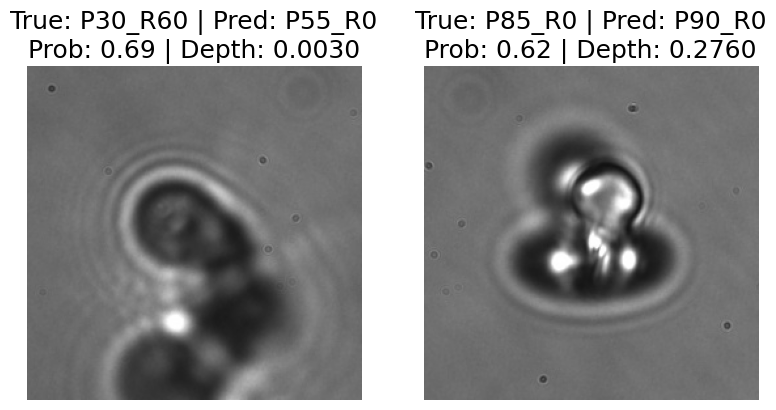

In [8]:
# --- Pose Model Error Analysis ---
print("=== Pose Model Error Analysis ===")

pose_arch = (
    BEST_POSE_MODEL_SINGLE_TASK.split("_")[0]
    + "_"
    + BEST_POSE_MODEL_SINGLE_TASK.split("_")[1]
)  # e.g. vgg11_bn
if "resnet" in BEST_POSE_MODEL_SINGLE_TASK:
    pose_arch = BEST_POSE_MODEL_SINGLE_TASK.split("_")[0]

print(f"Loading Pose Model: {BEST_POSE_MODEL_SINGLE_TASK} ({pose_arch})")

num_classes = len(dataset.idx_to_label)
model_pose = get_model(pose_arch, num_outputs=num_classes, in_channels=1)
model_path = f"{MODEL_DIR}/{BEST_POSE_MODEL_SINGLE_TASK}"

try:
    checkpoint = torch.load(model_path, map_location=device)
    model_pose.load_state_dict(checkpoint["model_state_dict"])
except FileNotFoundError:
    print(f"Model file not found at {model_path}. Please check path.")
    raise

model_pose.to(device)
model_pose.eval()

wrong_predictions = []

with torch.no_grad():
    for i, (image, (pose_target, depth_target)) in enumerate(dataloader):
        image = image.to(device)
        pose_target = pose_target.to(device)

        output = model_pose(image)
        probs = torch.softmax(output, dim=1)
        pred_prob, pred_idx = torch.max(probs, dim=1)

        if pred_idx.item() != pose_target.item():
            original_idx = test_dataset.indices[i]
            img_path = dataset.samples[original_idx][0]

            true_label = dataset.idx_to_label[pose_target.item()]
            pred_label = dataset.idx_to_label[pred_idx.item()]
            depth_val = depth_target.item()

            wrong_predictions.append(
                {
                    "path": img_path,
                    "true_label": true_label,
                    "pred_label": pred_label,
                    "prob": pred_prob.item(),
                    "depth": depth_val,
                }
            )

print(f"Found {len(wrong_predictions)} wrong predictions.")

# Display wrong predictions
if len(wrong_predictions) > 0:
    cols = 5
    rows = (len(wrong_predictions) + cols - 1) // cols
    plt.figure(figsize=(20, 4 * rows))

    for i, item in enumerate(wrong_predictions):
        img = Image.open(item["path"])
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(
            f"True: {item['true_label']} | Pred: {item['pred_label']}\nProb: {item['prob']:.2f} | Depth: {item['depth']:.4f}",
            fontsize=18,
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()

=== Depth Model Error Analysis ===
Loading Depth Model: alexnet_depth_augmented.pth (alexnet)

RMSE per Label:
      label      RMSE
24   P50_R0  0.082325
31  P60_R45  0.048240
20  P45_R30  0.047171
18  P45_R10  0.044752
7    P25_R0  0.042269
39   P90_R0  0.041829
36   P75_R0  0.041818
27   P60_R0  0.041083
35   P70_R0  0.038689
26    P5_R0  0.038133
28  P60_R10  0.036766
12  P30_R45  0.034824
15   P35_R0  0.034022
22   P45_R5  0.033981
23  P45_R60  0.033921
30  P60_R30  0.033593
0     P0_R0  0.032649
37   P80_R0  0.031625
1    P10_R0  0.031531
25   P55_R0  0.030768
5   P15_R45  0.029340
3   P15_R15  0.028949
16   P40_R0  0.027134
13   P30_R5  0.025710
2    P15_R0  0.025658
17   P45_R0  0.025247
8    P30_R0  0.024930
33  P60_R60  0.024656
38   P85_R0  0.023511
6    P15_R5  0.023110
11  P30_R30  0.022572
21  P45_R45  0.021745
14  P30_R60  0.021625
29  P60_R15  0.021365
34   P65_R0  0.020674
4   P15_R30  0.019738
9   P30_R10  0.019284
32   P60_R5  0.018109
19  P45_R15  0.016115
10  P30_R

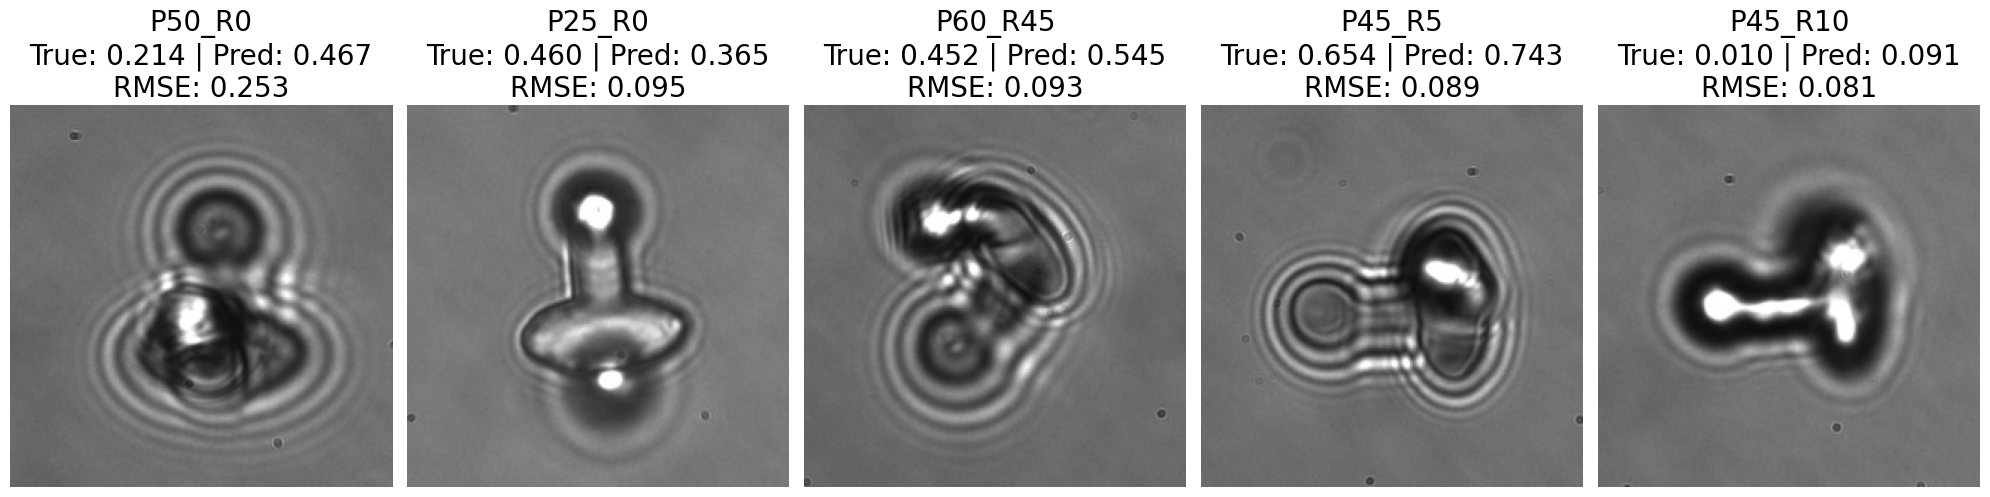

In [6]:
# --- Depth Model Error Analysis ---
print("=== Depth Model Error Analysis ===")

# Extract architecture
depth_arch = BEST_DEPTH_MODEL_SINGLE_TASK.split("_")[0]  # e.g. alexnet
print(f"Loading Depth Model: {BEST_DEPTH_MODEL_SINGLE_TASK} ({depth_arch})")

model_depth = get_model(depth_arch, num_outputs=1, in_channels=1)
model_path = f"{MODEL_DIR}/{BEST_DEPTH_MODEL_SINGLE_TASK}"

try:
    checkpoint = torch.load(model_path, map_location=device)
    model_depth.load_state_dict(checkpoint["model_state_dict"])
except FileNotFoundError:
    print(f"Model file not found at {model_path}. Please check path.")
    raise

model_depth.to(device)
model_depth.eval()

depth_data = []

with torch.no_grad():
    for i, (image, (pose_target, depth_target)) in enumerate(dataloader):
        image = image.to(device)
        depth_target = depth_target.to(device).float()

        output = model_depth(image)
        pred_depth = output.item()
        true_depth = depth_target.item()

        mse = (pred_depth - true_depth) ** 2
        rmse_sample = np.sqrt(mse)

        label_str = dataset.idx_to_label[pose_target.item()]

        original_idx = test_dataset.indices[i]
        img_path = dataset.samples[original_idx][0]

        depth_data.append(
            {
                "label": label_str,
                "true_depth": true_depth,
                "pred_depth": pred_depth,
                "rmse": rmse_sample,
                "mse": mse,
                "path": img_path,
            }
        )

df_depth = pd.DataFrame(depth_data)

# 1. RMSE per label
rmse_per_label = df_depth.groupby("label")["mse"].mean().apply(np.sqrt).reset_index()
rmse_per_label.rename(columns={"mse": "RMSE"}, inplace=True)
rmse_per_label = rmse_per_label.sort_values("RMSE", ascending=False)

print("\nRMSE per Label:")
print(rmse_per_label)

# 2. Top 5 largest RMSE images
print("\nTop 5 Images with Largest RMSE:")
top5_errors = df_depth.nlargest(5, "rmse")

if len(top5_errors) > 0:
    cols = 5
    rows = (len(top5_errors) + cols - 1) // cols
    plt.figure(figsize=(20, 5 * rows))

    for i, (_, row) in enumerate(top5_errors.iterrows()):
        img = Image.open(row["path"])
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(
            f"{row['label']}\nTrue: {row['true_depth']:.3f} | Pred: {row['pred_depth']:.3f}\nRMSE: {row['rmse']:.3f}",
            fontsize=20,
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()